# 前準備

In [1]:
!pip install linearmodels

You should consider upgrading via the '/Users/s13592/Documents/project/intro_to_impact_evaluation_with_python/.venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from linearmodels.panel import PanelOLS

URL_ORGAN_SHORT = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch4_organ_donations_short.csv'
URL_ORGAN_FULL = 'https://raw.githubusercontent.com/HirotakeIto/intro_to_impact_evaluation_with_python/main/data/ch4_organ_donations_full.csv'

# DIDの発想に基づく施策効果分析

In [3]:
# データの読み込み
df_organ_donations_short= pd.read_csv(URL_ORGAN_SHORT)
df_organ_donations_short.head()

,State,Quarter,Rate,Quarter_Num,IsTreatmentGroup,AfterTreatment,IsTreatment
0,Alaska,Q22011,0.7700,3,0,0,0
1,Alaska,Q32011,0.7800,4,0,1,0
2,Arizona,Q22011,0.2261,3,0,0,0
3,Arizona,Q32011,0.2503,4,0,1,0
4,California,Q22011,0.2743,3,1,0,0


In [4]:
# 4状況ごとのアウトカムの計算
df_organ_donations_short.groupby(['IsTreatmentGroup', 'AfterTreatment'])['Rate'].mean().reset_index()

,IsTreatmentGroup,AfterTreatment,Rate
0,0,0,0.449015
1,0,1,0.459881
2,1,0,0.274300
3,1,1,0.263600


In [5]:
(26.4 - 27.4) - (46.0 - 44.9)

-2.1000000000000014

# 実例：DIDによる訴求内容変更施策の分析

In [6]:
# 推定
result = smf.ols("Rate ~ IsTreatment + C(State) + C(Quarter_Num)", data=df_organ_donations_short).fit()
# 標準誤差の補正
result_correted = result.get_robustcov_results('cluster', groups=df_organ_donations_short['State'])
# 結果の出力
result_correted.summary().tables[1]

/Users/s13592/Documents/project/intro_to_impact_evaluation_with_python/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7696,0.004,216.842,0.000,0.762,0.777
C(State)[T.Arizona],-0.5368,8.3e-16,-6.47e+14,0.000,-0.537,-0.537
C(State)[T.California],-0.4953,0.004,-139.552,0.000,-0.503,-0.488
C(State)[T.Colorado],-0.1024,1e-15,-1.02e+14,0.000,-0.102,-0.102
C(State)[T.Connecticut],-0.3758,9.61e-16,-3.91e+14,0.000,-0.376,-0.376
C(State)[T.District of Columbia],-0.4262,8.3e-16,-5.13e+14,0.000,-0.426,-0.426
C(State)[T.Florida],-0.3686,9.42e-16,-3.91e+14,0.000,-0.369,-0.369
C(State)[T.Hawaii],-0.3467,8.25e-16,-4.2e+14,0.000,-0.347,-0.347
C(State)[T.Louisiana],-0.1966,8.59e-16,-2.29e+14,0.000,-0.197,-0.197
C(State)[T.Maryland],-0.3115,1.08e-15,-2.89e+14,0.000,-0.312,-0.312


- 本のために一部を省略して表示

In [7]:
result_table_abbv = result_correted.summary().tables[1]
for i in range(4, 26):
    result_table_abbv.pop(4)
result_table_abbv

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7696,0.004,216.842,0.000,0.762,0.777
C(State)[T.Arizona],-0.5368,8.3e-16,-6.47e+14,0.000,-0.537,-0.537
C(State)[T.California],-0.4953,0.004,-139.552,0.000,-0.503,-0.488
C(State)[T.Wisconsin],-0.2046,9.59e-16,-2.13e+14,0.000,-0.205,-0.205
C(State)[T.Wyoming],-0.1826,8.28e-16,-2.21e+14,0.000,-0.183,-0.183
C(Quarter_Num)[T.4],0.0109,0.007,1.531,0.138,-0.004,0.025
IsTreatment,-0.0216,0.007,-3.038,0.005,-0.036,-0.007


- linermodelsを使っても同じ結果になることを確認

In [8]:
mod = PanelOLS.from_formula("Rate ~ IsTreatment + EntityEffects + TimeEffects", data=df_organ_donations_short.set_index(["State", "Quarter_Num"]))
result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
IsTreatment,-0.0216,0.0070,-3.0673,0.0051,-0.0360,-0.0071


# 2期間以上のデータの場合のDID
## 実例：イベントスタディによる訴求内容変更施策の分析

### 二期間DIDとして分析

In [9]:
# データの読み込み
df_organ_donations_full= pd.read_csv(URL_ORGAN_FULL)
df_organ_donations_full.head(10)

,State,Quarter,Rate,Quarter_Num,IsTreatmentGroup,AfterTreatment,IsTreatment
0,Alaska,Q42010,0.7500,1,0,0,0
1,Alaska,Q12011,0.7700,2,0,0,0
2,Alaska,Q22011,0.7700,3,0,0,0
3,Alaska,Q32011,0.7800,4,0,1,0
4,Alaska,Q42011,0.7800,5,0,1,0
5,Alaska,Q12012,0.7900,6,0,1,0
6,Arizona,Q42010,0.2634,1,0,0,0
7,Arizona,Q12011,0.2092,2,0,0,0
8,Arizona,Q22011,0.2261,3,0,0,0
9,Arizona,Q32011,0.2503,4,0,1,0


In [10]:
# 推定
result = smf.ols("Rate ~ IsTreatment + C(State) + C(Quarter_Num)", data=df_organ_donations_short).fit()
# 標準誤差の補正
result_correted = result.get_robustcov_results('cluster', groups=df_organ_donations_short['State'])
# 結果の出力
result_correted.summary().tables[1]

/Users/s13592/Documents/project/intro_to_impact_evaluation_with_python/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 28, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7696,0.004,216.842,0.000,0.762,0.777
C(State)[T.Arizona],-0.5368,8.3e-16,-6.47e+14,0.000,-0.537,-0.537
C(State)[T.California],-0.4953,0.004,-139.552,0.000,-0.503,-0.488
C(State)[T.Colorado],-0.1024,1e-15,-1.02e+14,0.000,-0.102,-0.102
C(State)[T.Connecticut],-0.3758,9.61e-16,-3.91e+14,0.000,-0.376,-0.376
C(State)[T.District of Columbia],-0.4262,8.3e-16,-5.13e+14,0.000,-0.426,-0.426
C(State)[T.Florida],-0.3686,9.42e-16,-3.91e+14,0.000,-0.369,-0.369
C(State)[T.Hawaii],-0.3467,8.25e-16,-4.2e+14,0.000,-0.347,-0.347
C(State)[T.Louisiana],-0.1966,8.59e-16,-2.29e+14,0.000,-0.197,-0.197
C(State)[T.Maryland],-0.3115,1.08e-15,-2.89e+14,0.000,-0.312,-0.312


- 上記のテーブルの省略版

In [11]:
result_table_abbv = result_correted.summary().tables[1]
for i in range(4, 26):
    result_table_abbv.pop(4)
result_table_abbv

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7696,0.004,216.842,0.000,0.762,0.777
C(State)[T.Arizona],-0.5368,8.3e-16,-6.47e+14,0.000,-0.537,-0.537
C(State)[T.California],-0.4953,0.004,-139.552,0.000,-0.503,-0.488
C(State)[T.Wisconsin],-0.2046,9.59e-16,-2.13e+14,0.000,-0.205,-0.205
C(State)[T.Wyoming],-0.1826,8.28e-16,-2.21e+14,0.000,-0.183,-0.183
C(Quarter_Num)[T.4],0.0109,0.007,1.531,0.138,-0.004,0.025
IsTreatment,-0.0216,0.007,-3.038,0.005,-0.036,-0.007


### イベントスタディによる分析

In [12]:
# 時間に関するダミー変数を作成
quarter_dummies = pd.get_dummies(df_organ_donations_full['Quarter_Num'], prefix='QuarterNum', drop_first=False)
df_regression = pd.concat([df_organ_donations_full, quarter_dummies], axis=1)

In [13]:
df_regression.head(10)

,State,Quarter,Rate,Quarter_Num,IsTreatmentGroup,AfterTreatment,IsTreatment,QuarterNum_1,QuarterNum_2,QuarterNum_3,QuarterNum_4,QuarterNum_5,QuarterNum_6
0,Alaska,Q42010,0.7500,1,0,0,0,1,0,0,0,0,0
1,Alaska,Q12011,0.7700,2,0,0,0,0,1,0,0,0,0
2,Alaska,Q22011,0.7700,3,0,0,0,0,0,1,0,0,0
3,Alaska,Q32011,0.7800,4,0,1,0,0,0,0,1,0,0
4,Alaska,Q42011,0.7800,5,0,1,0,0,0,0,0,1,0
5,Alaska,Q12012,0.7900,6,0,1,0,0,0,0,0,0,1
6,Arizona,Q42010,0.2634,1,0,0,0,1,0,0,0,0,0
7,Arizona,Q12011,0.2092,2,0,0,0,0,1,0,0,0,0
8,Arizona,Q22011,0.2261,3,0,0,0,0,0,1,0,0,0
9,Arizona,Q32011,0.2503,4,0,1,0,0,0,0,1,0,0


In [14]:
# 分析
result = smf.ols(
    "Rate ~ QuarterNum_1:IsTreatmentGroup + QuarterNum_2:IsTreatmentGroup + QuarterNum_4:IsTreatmentGroup + QuarterNum_5:IsTreatmentGroup + QuarterNum_6:IsTreatmentGroup + C(State) + C(Quarter_Num)", 
    data=df_regression
).fit()
# 標準誤差の補正
result_correted = result.get_robustcov_results('cluster', groups=df_regression['State'])
# 結果の出力
result_correted.summary().tables[1]

/Users/s13592/Documents/project/intro_to_impact_evaluation_with_python/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 36, but rank is 5
  warnings.warn('covariance of constraints does not have full '


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7657,0.005,142.389,0.000,0.755,0.777
C(State)[T.Arizona],-0.5329,1.21e-15,-4.41e+14,0.000,-0.533,-0.533
C(State)[T.California],-0.4962,0.003,-158.861,0.000,-0.503,-0.490
C(State)[T.Colorado],-0.1055,1.34e-15,-7.86e+13,0.000,-0.105,-0.105
C(State)[T.Connecticut],-0.3802,2e-15,-1.9e+14,0.000,-0.380,-0.380
C(State)[T.District of Columbia],-0.4300,1.79e-15,-2.4e+14,0.000,-0.430,-0.430
C(State)[T.Florida],-0.3770,1.47e-15,-2.57e+14,0.000,-0.377,-0.377
C(State)[T.Hawaii],-0.3524,1.47e-15,-2.39e+14,0.000,-0.352,-0.352
C(State)[T.Louisiana],-0.2167,1.68e-15,-1.29e+14,0.000,-0.217,-0.217
C(State)[T.Maryland],-0.3076,1.58e-15,-1.95e+14,0.000,-0.308,-0.308


In [15]:
result_table_abbv = result_correted.summary().tables[1]
for i in range(4, 30):
    result_table_abbv.pop(4)
result_table_abbv

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7657,0.005,142.389,0.000,0.755,0.777
C(State)[T.Arizona],-0.5329,1.21e-15,-4.41e+14,0.000,-0.533,-0.533
C(State)[T.California],-0.4962,0.003,-158.861,0.000,-0.503,-0.490
C(Quarter_Num)[T.4],0.0156,0.007,2.143,0.042,0.001,0.031
C(Quarter_Num)[T.5],0.0114,0.006,1.945,0.063,-0.001,0.024
C(Quarter_Num)[T.6],0.0167,0.013,1.271,0.215,-0.010,0.044
QuarterNum_1:IsTreatmentGroup,-0.0029,0.006,-0.527,0.603,-0.014,0.009
QuarterNum_2:IsTreatmentGroup,0.0063,0.002,2.528,0.018,0.001,0.011
QuarterNum_4:IsTreatmentGroup,-0.0216,0.006,-3.898,0.001,-0.033,-0.010
QuarterNum_5:IsTreatmentGroup,-0.0203,0.005,-4.127,0.000,-0.030,-0.010


/var/folders/6s/tb_rn7ds7435kf9r5l7mgxs8v79db2/T/ipykernel_37879/3579214656.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_correted.summary2().tables[1]


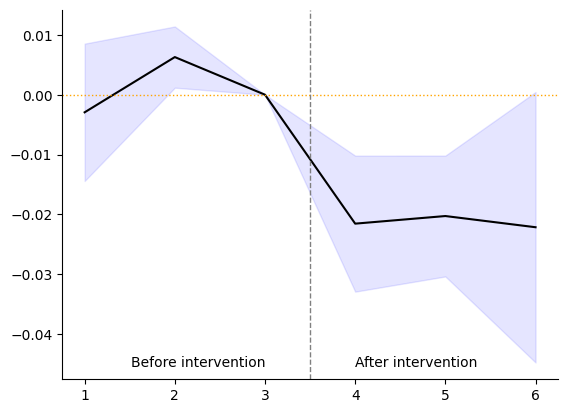

In [16]:
# 利用する情報のセットアップ
mapping_col_to_time = {
    'QuarterNum_1:IsTreatmentGroup': 1, 
    'QuarterNum_2:IsTreatmentGroup': 2,
    'QuarterNum_4:IsTreatmentGroup': 4,
    'QuarterNum_5:IsTreatmentGroup': 5,
    'QuarterNum_6:IsTreatmentGroup': 6,    
}
colname_time, colname_coef, colname_lower, colname_upper = 'time', 'Coef.', '[0.025', '0.975]'
# プロットする元データを作成する
df_plot = (
    result_correted.summary2().tables[1]
    .loc[mapping_col_to_time.keys()]
    .reset_index()
    .assign(**{colname_time: lambda dfx: dfx['index'].replace(mapping_col_to_time)})
    .append(pd.Series({colname_time: 3, colname_coef: 0, colname_lower: 0, colname_upper: 0}), True)
    .sort_values(colname_time)
)
# プロットをする
fig, ax = plt.subplots()
ax.plot(df_plot[colname_time], df_plot[colname_coef], color='black')
ax.fill_between(df_plot[colname_time], df_plot[colname_lower], df_plot[colname_upper], color='blue', alpha=.1)
ax.axhline(0, color='orange', linewidth = 1, linestyle='dotted')
ax.axvline(3.5, color='grey', linewidth = 1, linestyle='dashed')
ax.text(3.5 - 0.5, df_plot[colname_lower].min(), 'Before intervention', horizontalalignment='right', verticalalignment='center')
ax.text(3.5 + 0.5, df_plot[colname_lower].min(), 'After intervention', horizontalalignment='left', verticalalignment='center')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# DiDの仮定チェック

## プレトレンドチェック

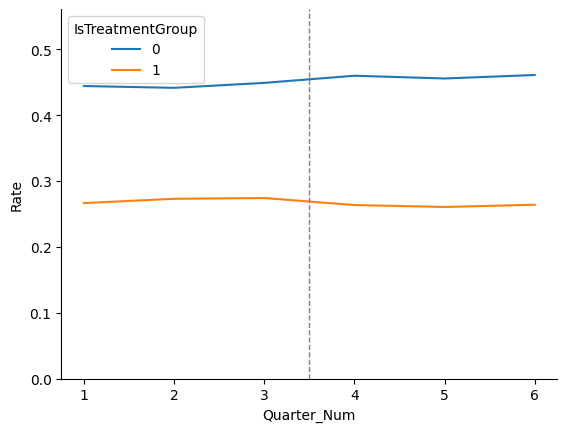

In [17]:
# 集計
df_plot = df_organ_donations_full.groupby(['IsTreatmentGroup', 'Quarter_Num'])['Rate'].mean().reset_index()
# プロット
fig, ax = plt.subplots()
sns.lineplot(data=df_plot, x="Quarter_Num", y="Rate", hue='IsTreatmentGroup', ax=ax)
plt.axvline(3.5, color='grey', linewidth = 1, linestyle='dashed')
plt.ylim(0, df_plot['Rate'].max() + 0.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()